# TEI serialization issues

## Introduction

There is one bug and one uncertainty in CollateX TEI output. Here are the details.

## Data

The three witnesses read:

* A: Hello h[pb/]orse goodbye
* B: Hello hor[pb/]se goodbye
* C: Hello bunny goodbye

We've used square brackets instead of angle brackets because the SVG output tries to parse angle brackets as markup, instead of rendering them.

After stripping page breaks, we expect A and B to agree against C, with variation only in the third token. The TEI serialization currently exhibits two bugs, one with two witnesses and one with three.

## Two witnesses

### Create a collation object and add witnesses

We print each token to verify that normalization is removing our fake page breaks.

In [1]:
from collatex import *
import re
collation = Collation()
def normalize(inputText):
    result = re.sub(r'\[.+?\]',r'',inputText).rstrip()
    return result
def processToken(inputText):
    result = {"t": inputText, "n": normalize(inputText)}
    print(result)
    return result
def processWitness(inputText):
    siglum, rdg = inputText
    return {"id": siglum, "tokens": \
            [processToken(token) for token in re.findall(r'\S+\s*', rdg)]}
witnesses = [('A', 'Hello h[pb/]orse goodbye'), ('B', 'Hello hor[pb/]se goodbye')]
collation = {"witnesses": [processWitness(witness) for witness in witnesses]}

{'t': 'Hello ', 'n': 'Hello'}
{'t': 'h[pb/]orse ', 'n': 'horse'}
{'t': 'goodbye', 'n': 'goodbye'}
{'t': 'Hello ', 'n': 'Hello'}
{'t': 'hor[pb/]se ', 'n': 'horse'}
{'t': 'goodbye', 'n': 'goodbye'}


### Plain text

The plain text collation is correct, although we can't see which columns have agreement and which are aligned but don't agree.

In [2]:
alignment_table = collate(collation, segmentation=False)
print(alignment_table)

+---+-------+------------+---------+
| A | Hello | h[pb/]orse | goodbye |
| B | Hello | hor[pb/]se | goodbye |
+---+-------+------------+---------+


### SVG

SVG output is correct, and shows that A and B form a single token in the variant graph.

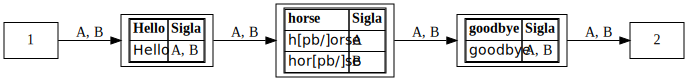

In [3]:
collate(collation, segmentation=False, output="svg")

### HTML2

HTML2 also shows that the second token has no variation after normalization.

In [4]:
collate(collation, segmentation=False, output="html2")

### XML

XML output is correct. Like the plain text table, it doesn’t distinguish moments of agreement from moments of variation

In [5]:
xml_output = collate(collation, segmentation=False, output="xml")
print(xml_output)

<root><app><rdg wit="#A">Hello </rdg><rdg wit="#B">Hello </rdg></app><app><rdg wit="#A">h[pb/]orse </rdg><rdg wit="#B">hor[pb/]se </rdg></app><app><rdg wit="#A">goodbye</rdg><rdg wit="#B">goodbye</rdg></app></root>


### TEI

**Bug** TEI output outputs only the third token.

In [6]:
tei_output = collate(collation, segmentation=False, output="tei", indent=True)
print(tei_output)

<p>goodbye
</p>


## Three witnesses

Now we add a third witness, which differs after normalization from the other two.

In [7]:
witnesses = [('A', 'Hello h[pb/]orse goodbye'), ('B', 'Hello hor[pb/]se goodbye'), ('C', 'Hello bunny goodbye')]
collation = {"witnesses": [processWitness(witness) for witness in witnesses]}

{'t': 'Hello ', 'n': 'Hello'}
{'t': 'h[pb/]orse ', 'n': 'horse'}
{'t': 'goodbye', 'n': 'goodbye'}
{'t': 'Hello ', 'n': 'Hello'}
{'t': 'hor[pb/]se ', 'n': 'horse'}
{'t': 'goodbye', 'n': 'goodbye'}
{'t': 'Hello ', 'n': 'Hello'}
{'t': 'bunny ', 'n': 'bunny'}
{'t': 'goodbye', 'n': 'goodbye'}


### Plain text

Plain text output is correct, but, as with two witnesses, it doesn’t show which columns are aligned and which are not

In [8]:
alignment_table = collate(collation, segmentation=False)
print(alignment_table)

+---+-------+------------+---------+
| A | Hello | h[pb/]orse | goodbye |
| B | Hello | hor[pb/]se | goodbye |
| C | Hello | bunny      | goodbye |
+---+-------+------------+---------+


### SVG

SVG output shows that the witnesses with page breaks are placed correctly on the same token

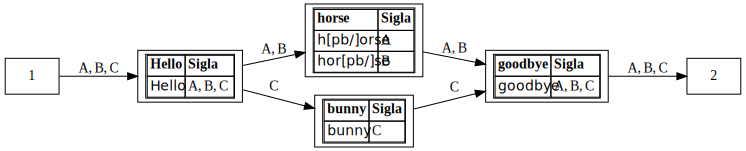

In [9]:
collate(collation, segmentation=False, output="svg")

### HTML2

HTML2 correctly shows that there is variation in the second token, but not the third. It is not able to show which witnesses agree

In [10]:
collate(collation, segmentation=False, output="html2")

### XML

XML output is correct, but does not show which positions agree and which disagree, or which witnesses agree with which in moments of variation

In [11]:
xml_output = collate(collation, segmentation=False, output="xml")
print(xml_output)

<root><app><rdg wit="#A">Hello </rdg><rdg wit="#B">Hello </rdg><rdg wit="#C">Hello </rdg></app><app><rdg wit="#A">h[pb/]orse </rdg><rdg wit="#B">hor[pb/]se </rdg><rdg wit="#C">bunny </rdg></app><app><rdg wit="#A">goodbye</rdg><rdg wit="#B">goodbye</rdg><rdg wit="#C">goodbye</rdg></app></root>


### TEI

**Issue** TEI outputs all three `<app>` elements this time, but it outputs A and B in separate `<rdg>` elements. It is not entirely clear whether this is the desired behavior. 

In [12]:
tei_output = collate(collation, segmentation=False, output="tei", indent=True)
print(tei_output)

<p>Hello
<app>
  <rdg wit="#A">h[pb/]orse </rdg>
  <rdg wit="#B">hor[pb/]se </rdg>
  <rdg wit="#C">bunny </rdg>
</app>

goodbye
</p>


### Issues

If A and B are output as part of the same `<rdg>` element, it is unclear what the correct output should be. There are several possibilities, none of which is clearly correct, or even satisfactory:

* Output the "n" value, which is the same for A and B. This is wrong because elsewhere we output "t", and not "n".
* Output one or the other "t" value arbitrarily. This is wrong because it’s arbitrary.
* Output both "t" values, along the lines of "h[pb/]orse ~ hor[pb/]se". This is wrong because if we care about both of them, it’s a moment of variation, and it belongs in the apparatus.
* Merge the "t" values into something like "h[pb/]or[pb/]se". This is wrong because, although it may be reasonably clear for page breaks (clearer if they include attributes that identify the edition, which we could add during the normalization step), it would become confusing with variation involving regular characters, e.g., capitalization or variant spellings.
* Output the "t" value from the "best witness". This is challenging not only because there isn’t necessarily a best witnesses, but also because, at least at the moment, the TEI output doesn’t know about preferred witnesses.

There is also the option of saying that "n" is just for alignment, and when it comes to output, if the "t" values are different, they should be in different `<rdg>` elements. This would let us express satisfaction with the current behavior, but this isn’t the only (or even the most likely) situation where we have different "t" values paired with the same "n". More likely is that "t" values may differ only in whether they have trailing white space, and in that case we don’t want to output them in separate `<rdg>` elements. We could work around that by stripping trailing white space from the "t" values, and not only from the "n", but that works only as long as we turn off segmentation, since otherwise the words would run together.